## Oncase Exploratory Data Analysis

Análise dos dados extraídos a partir do crawler nos blogs **Tecmundo** e **Tecnoblog**. 

Os dados foram armazendos em uma base local com MongoDB:
<br>
**database**: news
<br>
**collection**: tc_news

Cada registro é composto por 8 colunas, sendo elas:
* **_id**: Id gerado pelo MongoDB
* **link**: Url do artigo
* **author**: Nome do autor do artigo
* **blog**: Nome do blog ao qual o artigo pertence
* **date**: Data de publicação
* **tag**: Lista de tags utilizadas 
* **text**: Corpo do texto do artigo
* **title**: Titulo do artigo

In [191]:
import pymongo
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import iqr
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
# get mongodb collection
client = pymongo.MongoClient('localhost', 27017)
articles = client.news.tc_news

In [134]:
articles.find_one()

{'_id': ObjectId('5daf03731dd466f533340c25'),
 'link': 'https://tecnoblog.net/311651/facebook-instagram-sinalizar-noticias-falsas-posts-stories/',
 'author': 'Felipe Ventura',
 'blog': 'Tecnoblog',
 'date': '22/10/2019',
 'tag': 'Facebook,Fake news,Instagram,Notícias falsas',
 'text': 'O Facebook e o Instagram deixarão mais claro quando uma notícia falsa for postada no feed ou nos Stories: se a foto ou o vídeo tiver conteúdo considerado falso por uma agência independente de checagem de fatos, ele será borrado e terá o aviso de que a informação não procede. E quem tentar postar esse tipo de conteúdo receberá um aviso de que se trata de fake news, com links para saber mais a respeito. As novas medidas antecipam as eleições presidenciais de 2020 nos EUA.Ao longo do próximo mês, o Facebook e o Instagram vão rotular com mais destaque o conteúdo “que tenha sido marcado como falso ou parcialmente falso por uma agência de checagem de fatos independente parceira”, conforme explica a empresa em 

In [135]:
# entradas para criação do dataFrame
cursor = articles.find()
entries = list(cursor)

In [317]:
df = pd.DataFrame(entries)
df.head()

,_id,author,blog,date,link,tag,text,title
0,5daf03731dd466f533340c25,Felipe Ventura,Tecnoblog,22/10/2019,https://tecnoblog.net/311651/facebook-instagra...,"Facebook,Fake news,Instagram,Notícias falsas",O Facebook e o Instagram deixarão mais claro q...,Facebook e Instagram vão sinalizar notícias fa...
1,5daf03731dd466f533340c27,Felipe Ventura,Tecnoblog,18/10/2019,https://tecnoblog.net/311574/google-evitar-pro...,"Android,Google,horário de verão",O horário de verão não será aplicado em 2019 n...,Google ensina a evitar problemas no Android co...
2,5daf03731dd466f533340c29,Lucas Lima,Tecnoblog,18/10/2019,https://tecnoblog.net/311599/samsung-galaxy-s1...,"Samsung,Samsung Galaxy Note,Samsung Galaxy Not...",A Samsung prometeu para o início da próxima se...,Samsung orienta donos do Galaxy S10 e Note 10 ...
3,5daf03731dd466f533340c2b,Lucas Lima,Tecnoblog,18/10/2019,https://tecnoblog.net/311583/apple-deve-lancar...,"AirPods,Apple,Apple AirPods,Apple AirPods Pro","A Apple pode estar se preparando para lançar, ...",Apple deve lançar AirPods Pro com cancelamento...
4,5daf03731dd466f533340c2d,André Fogaça,Tecnoblog,18/10/2019,https://tecnoblog.net/311559/google-maps-ganha...,Google Maps,O Google anunciou nesta quinta-feira (17) que ...,Google Maps ganha recursos do Waze e permite i...


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2399 entries, 0 to 2398
Data columns (total 8 columns):
_id       2399 non-null object
author    2374 non-null object
blog      2399 non-null object
date      2115 non-null object
link      2399 non-null object
tag       2394 non-null object
text      2399 non-null object
title     2399 non-null object
dtypes: object(8)
memory usage: 150.0+ KB


A base de dados possui um total de **2399** artigos, alguns deles com dados faltantes como o nome do autor, a data de publicação e tag.

In [148]:
print('Artigos sem o nome do autor: ', df['author'].isna().sum())
print('Artigos sem a data de publicação: ', df['date'].isna().sum())
print('Artigos sem tag: ', df['tag'].isna().sum())

Artigos sem o nome do autor:  25
Artigos sem a data de publicação:  284
Artigos sem tag:  5


In [318]:
# transformando a coluna tag em lista
# df['tag'] = df['tag'].str.split(",")
type(df['tag'])

pandas.core.series.Series

In [149]:
# removendo a coluna _id, pois não será utilizada na análise
df.drop('_id', axis=1, inplace=True)
df.columns

Index(['author', 'blog', 'date', 'link', 'tag', 'text', 'title'], dtype='object')

#### author

In [152]:
print('Número de autores diferentes: ', df['author'].nunique())

Número de autores diferentes:  71


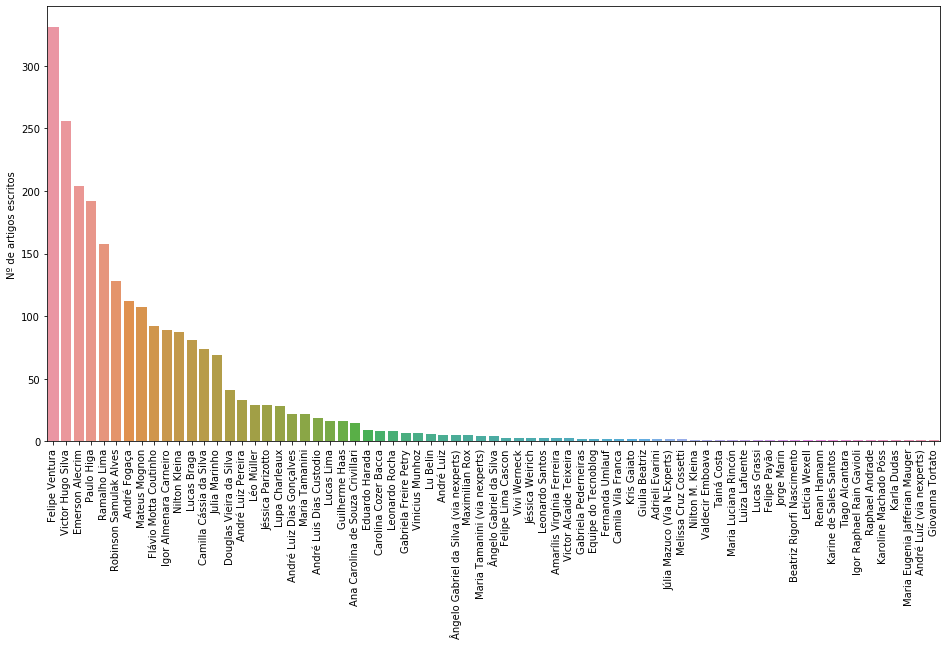

In [205]:
# número de artigos por autor
plt.figure(figsize=(16, 8))
authors = df['author'].value_counts()
sns.barplot(x=authors.index, y=authors)
plt.ylabel('Nº de artigos escritos')
plt.xticks(rotation=90)
plt.show()

In [187]:
# descrevendo pontos estatísticos
authors.describe()

count     71.000000
mean      33.436620
std       64.159785
min        1.000000
25%        1.000000
50%        4.000000
75%       28.500000
max      331.000000
Name: author, dtype: float64

De acordo com os valores estatísticos, temos uma média de 33 artigos por autor, até 25% dos autores escreveu apenas 1 artigos, até 50% escreveu 4 artigos e até 75% escreveu 28 artigos. Além disso, percebesse que temos um autor que escreveu 331 artigos, um número bem significativo em relação aos outros.

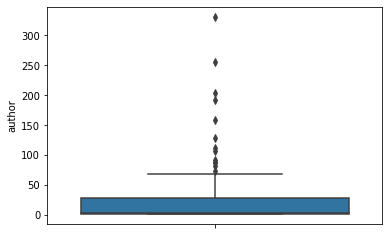

In [190]:
# Verificando outliers
sns.boxplot(y=authors)

In [201]:
# considerando outliers os valores 
# que estão além da faixa -1.5 x IQR to 1.5 x IQR
# sendo IQR (distância interquartil)
outliers = [ol for ol in authors.values if (ol > 1.5*iqr(authors)) or (ol < -1.5*iqr(authors))]
outliers

[331, 256, 204, 192, 158, 128, 112, 107, 92, 89, 87, 81, 74, 69]

In [204]:
print('Temos um total de {} outliers.'.format(len(outliers)))

Temos um total de 14 outliers.


In [281]:
# agrupando autores por blog
author_per_blog = df.groupby(['blog'])['author'].nunique()
author_per_blog

blog
Tecmundo     61
Tecnoblog    10
Name: author, dtype: int64

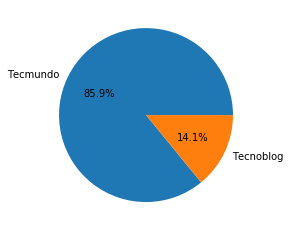

In [286]:
plt.pie(author_per_blog.values, labels=author_per_blog.index, autopct='%1.1f%%')
plt.show()

Pelo gráfico percebemos que o **Tecmundo** possui mais autores do que o Tecnoblog, sendo **85.9% do total de autores** (71 no total) da base de dados.

#### blog

In [289]:
# número de postagens em cada blog
df['blog'].value_counts()

Tecmundo     1200
Tecnoblog    1199
Name: blog, dtype: int64

Temos 1200 artigos do Tecmundo e 1199 artigos do Tecnoblog

#### tag

In [311]:
from collections import Counter

In [309]:
df.loc[3, 'tag']

['AirPods', 'Apple', 'Apple AirPods', 'Apple AirPods Pro']

In [316]:
Counter(df.loc[3, 'tag']).keys()

dict_keys(['AirPods', 'Apple', 'Apple AirPods', 'Apple AirPods Pro'])